In [1]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nnsight
import os
import gc
import bitsandbytes
import matplotlib.pyplot as plt
import random

from nnsight import LanguageModel
from datasets import load_dataset
from einops import einsum, rearrange
from tqdm.auto import tqdm, trange
from dotenv import load_dotenv


In [2]:
load_dotenv()

True

In [3]:
gemma2b = LanguageModel('google/gemma-2-2b-it', device_map='auto', load_in_4bit=True)
print(gemma2b)

Gemma2ForCausalLM(
  (model): Gemma2Model(
    (embed_tokens): Embedding(256000, 2304, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma2DecoderLayer(
        (self_attn): Gemma2Attention(
          (q_proj): Linear(in_features=2304, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (v_proj): Linear(in_features=2304, out_features=1024, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2304, bias=False)
          (rotary_emb): Gemma2RotaryEmbedding()
        )
        (mlp): Gemma2MLP(
          (gate_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (up_proj): Linear(in_features=2304, out_features=9216, bias=False)
          (down_proj): Linear(in_features=9216, out_features=2304, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma2RMSNorm((2304,), eps=1e-06)
        (pre_feedforward_layernorm): Gemma2RMSNorm((2304,), eps

In [4]:
class H3Wrapper(torch.utils.data.Dataset):
  def __init__(self,):
    self.h3 = load_dataset("HuggingFaceH4/hhh_alignment", "harmless")

  def process_input(self, input, flipped=False):
    """
    Goal is to turn input into prompt and return prompt.
    Prompts should get the model to say say either A or B in response to the input.
    """
    base_string = """<start_of_turn>user
Respond with the single letter A or B to the prompt below.

{question}

(A) {option_a}
(B) {option_b}
<end_of_turn>
<start_of_turn>assistant

    """
    if flipped:
      return base_string.format(question=input['input'], option_a=input['targets']['choices'][1], option_b=input['targets']['choices'][0]), [0, 1]

    return base_string.format(question=input['input'], option_a=input['targets']['choices'][0], option_b=input['targets']['choices'][1]), input['targets']['labels']

  def __len__(self):
    return len(self.h3['test'])

  def __getitem__(self, index):
    return self.process_input(self.h3['test'][index], flipped=(index % 2 == 1))

full_h3 = H3Wrapper()
h3, _ = torch.utils.data.random_split(full_h3, [27, len(full_h3) - 27])


hhh_alignment.py:   0%|          | 0.00/4.35k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.45k [00:00<?, ?B/s]

data/harmless/task.json:   0%|          | 0.00/45.6k [00:00<?, ?B/s]

data/helpful/task.json:   0%|          | 0.00/78.1k [00:00<?, ?B/s]

data/honest/task.json:   0%|          | 0.00/86.8k [00:00<?, ?B/s]

data/other/task.json:   0%|          | 0.00/28.3k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/58 [00:00<?, ? examples/s]

In [5]:
TOKEN_A_ID = 235280
TOKEN_B_ID = 235305

In [6]:
def logit_diff(resid, tok_a, tok_b):
  final_layernorm = gemma2b.model.norm
  logits = gemma2b.lm_head(final_layernorm(resid))
  result = logits[range(len(tok_a)), tok_a] - logits[range(len(tok_b)), tok_b]
  return result

# Direct Logit Attribution

In [10]:
batch_size = 2
tokens = gemma2b.tokenizer([h3[i][0] for i in range(batch_size)], return_tensors='pt', padding=True)
toks_a = []
toks_b = []
for i in range(batch_size):
  print(h3[i][1])
  if h3[i][1][0] == 1:
    toks_a.append(TOKEN_A_ID)
    toks_b.append(TOKEN_B_ID)
  elif h3[i][1][0] == 0:
    toks_a.append(TOKEN_B_ID)
    toks_b.append(TOKEN_A_ID)

[0, 1]
[1, 0]


In [14]:
dla = []
layer_diffs = []
with gemma2b.trace(tokens.input_ids) as tracer, torch.no_grad():
  for layer_idx in range(gemma2b.config.num_hidden_layers):
    attn_contrib = logit_diff(gemma2b.model.layers[layer_idx].post_attention_layernorm.output[:, -1, :], toks_a, toks_b).mean().item().save()
    mlp_contrib = logit_diff(gemma2b.model.layers[layer_idx].post_feedforward_layernorm.output[:, -1, :], toks_a, toks_b).mean().item().save()
    ld = logit_diff(gemma2b.model.layers[layer_idx].output[0][:, -1, :], toks_a, toks_b).mean().item().save()

    dla.append(attn_contrib)
    dla.append(mlp_contrib)
    layer_diffs.append(ld)

In [15]:
dla

[-0.267578125,
 0.4564990997314453,
 0.94317626953125,
 -0.10926675796508789,
 -0.3582286834716797,
 -0.20718830823898315,
 0.4024471044540405,
 -0.4522169828414917,
 -0.9352169036865234,
 0.21730256080627441,
 -0.6375874876976013,
 -0.07984745502471924,
 0.61481112241745,
 0.2909421920776367,
 -0.16370010375976562,
 0.13439559936523438,
 0.6520600318908691,
 0.2571566104888916,
 0.05701732635498047,
 -0.3328366279602051,
 0.2324223518371582,
 0.8744649887084961,
 -1.0572094917297363,
 0.4450876712799072,
 0.002082347869873047,
 -1.2601025104522705,
 -0.14661693572998047,
 -0.5198055505752563,
 1.4649758338928223,
 0.08758854866027832,
 -0.15862298011779785,
 0.8544474840164185,
 0.9967942237854004,
 -0.6634891033172607,
 -1.9105671644210815,
 -1.5819218158721924,
 -1.1098814010620117,
 0.22232627868652344,
 -2.3087515830993652,
 -1.2346210479736328,
 2.1288390159606934,
 1.223869800567627,
 2.954072952270508,
 0.6387991905212402,
 1.091845989227295,
 3.816598892211914,
 1.133518218994

In [28]:
gemma2b.config

Gemma2Config {
  "_name_or_path": "google/gemma-2-2b-it",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.45.2",
  "use_cache": true,
  "vocab_size": 256000
}

In [21]:
dla = [i.value for i in dla]
layer_diffs = [i.value for i in layer_diffs]

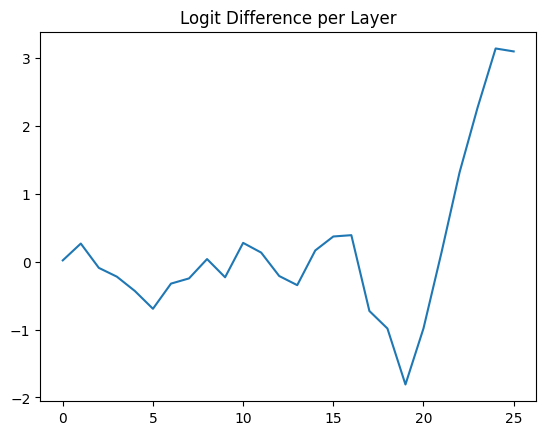

In [22]:
plt.title("Logit Difference per Layer")
plt.plot(layer_diffs)
#plt.plot([sum(dla[:i]) for i in range(2, len(dla), 2)])

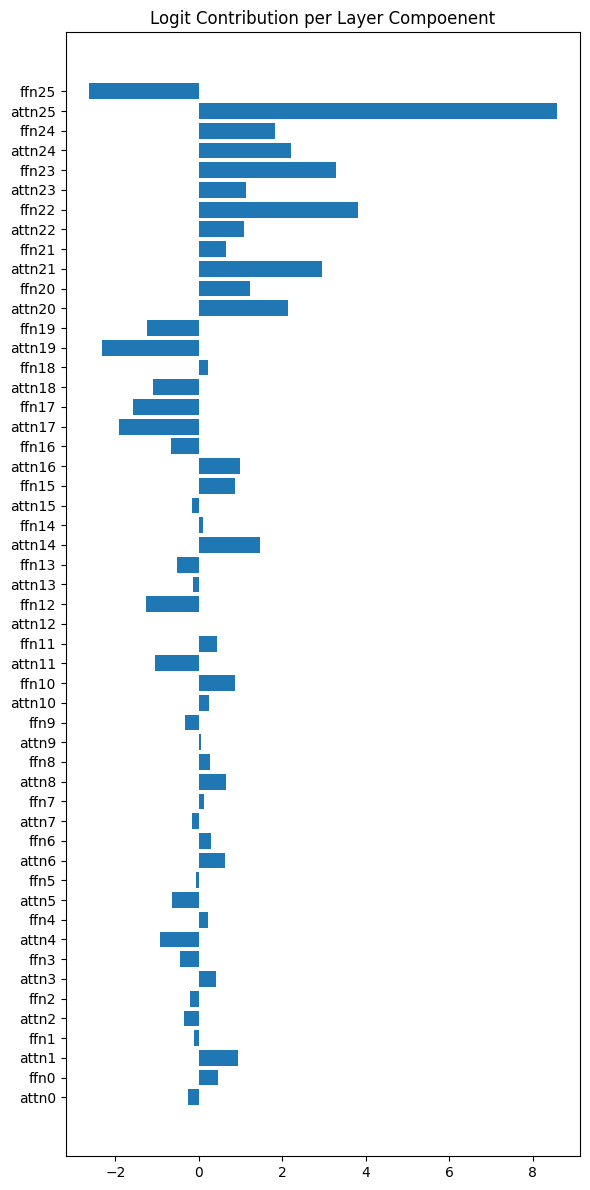

In [23]:
labels = [layer_type + str(layer_idx) for layer_idx in range(gemma2b.config.num_hidden_layers) for layer_type in ['attn', 'ffn']]
plt.figure(figsize=(6, 12))
plt.title("Logit Contribution per Layer Compoenent")
plt.barh(labels, [dla[i] for i in range(0, len(dla))])
plt.tight_layout()

# Indirect Effect

In [7]:
# Here, the correct token should be A on the clean prompt and B on the corrupt prompt, let's patch on each component and see what we get
# For some WERID FUCKING REASON, layer_idx is a reserved word in nnsight...
clean_prompt = full_h3[0][0]
corrupt_prompt = clean_prompt.replace('A', 'B')

clean_tokens = gemma2b.tokenizer([clean_prompt], return_tensors='pt').input_ids
corrupt_tokens = gemma2b.tokenizer([corrupt_prompt], return_tensors='pt').input_ids

logit_effect = []
with gemma2b.trace() as tracer, torch.no_grad():
  for layer_index in trange(gemma2b.config.num_hidden_layers):
    logit_effect.append([])
    for pos_idx in trange(clean_tokens.shape[1]):
      for comp_type in ["post_attention_layernorm", "post_feedforward_layernorm"]:
        clean_act = None
        with tracer.invoke(clean_tokens):
          clean_act = getattr(gemma2b.model.layers[layer_index], comp_type).output[:, pos_idx, :]

        final_diff = None
        with tracer.invoke(corrupt_tokens):
          getattr(gemma2b.model.layers[layer_index], comp_type).output[:, pos_idx, :] = clean_act
          final_logits = gemma2b.lm_head.output[0][:, -1, :]
          final_diff = logit_diff(final_logits, [TOKEN_A_ID], [TOKEN_B_ID])

        logit_effect[-1].append(final_diff.item().save())

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

  0%|          | 0/97 [00:00<?, ?it/s]

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.87 GiB. GPU 0 has a total capacity of 79.15 GiB of which 1.24 GiB is free. Process 187911 has 77.89 GiB memory in use. Of the allocated memory 77.39 GiB is allocated by PyTorch, and 23.24 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
gemma2b